In [1]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.ticker as ticker

In [2]:
injuryData = pd.read_csv("~/Documents/Job Search - 2023/NBA_Injury_Predictor/Injuries.csv")

In [3]:
injuryData.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
injuryData.rename(columns={'Notes': 'Injury Type'}, inplace=True)
injuryData.rename(columns={'Relinquished': 'Player'}, inplace=True)

### We want to separate the dataset by year to get a good idea of the total number of injuries that have occured annually

In [4]:
# Setting the objects in the column to a pandas datetime object
injuryData['Date'] = pd.to_datetime(injuryData['Date'])

#Grouping rows by 'decade' column
injuryData['Year'] = (injuryData['Date'].dt.year)



### Let's now remove all rows where the players have been acquired back from the IL 


In [5]:
# Removing the Acquired column removes all duplicates 
injuryData = injuryData[injuryData['Acquired'].isna()]
del injuryData['Acquired']

### Now let's calculate the total sum of injuries for each Year

## `It is important to note that the NBA did not have and IR/IL until the 1989-1990 season. Prior to this injured players were still members of the active roster. For this reason, it's likely many injuries do not appear in the dataset.`

In [6]:
# We only want to include data from the years after 1989 
yearly_injuries = {}
total_injuries = 0
for year, group in injuryData.groupby('Year'):
    if year > 1989: 
        injuries = group.shape[0]
        yearly_injuries[year] = injuries
        total_injuries += injuries
#         print(f"Year: {year} Injuries: {injuries}")
#         print(f"Total Injuries: {total_injuries}")
#         print("---------------------------------------------")
df = pd.DataFrame(yearly_injuries.items(), columns=['Year', 'Injuries'])
condition1 = df['Year'].astype(int) <= 2015
df.loc[condition1, 'Players'] = 354

# Set the condition for the second range of years (1996 onwards)
condition2 = df['Year'].astype(int) > 2015
df.loc[condition2, 'Players'] = 450
df      

,Year,Injuries,Players
0,1990,64,354.0
1,1991,66,354.0
2,1992,28,354.0
3,1993,33,354.0
4,1994,127,354.0
5,1995,245,354.0
6,1996,277,354.0
7,1997,290,354.0
8,1998,157,354.0
9,1999,396,354.0


In [7]:
# calculating the correlation for the two features I will use to train my model
Players_corr = df['Players'].corr(df['Injuries'])
Year_corr = df['Year'].corr(df['Injuries'])

print("Correlation for Players feature:", Players_corr)
print("Correlation for Year feature:", Year_corr)

Correlation for Players feature: 0.5759226257184823
Correlation for Year feature: 0.8285992890740163


In [8]:
# plt.scatter(df['Year'], df['Injuries'])

# # Add a title
# plt.title('Correlation between year and total injuries')

# # Save the plot
# plt.savefig('scatter_plot.png')

In [9]:
#Using Linear Regression function to fit our model
train_data = df[:26]

X_train = np.array(train_data[['Year', 'Players']]).reshape(-1, 2)
y_train = train_data['Injuries']
reg = LinearRegression()


fit_model = reg.fit(X_train, y_train)
print(df.shape)
X_train.shape

(34, 3)


(26, 2)

In [10]:
# using a scikit-learn attribute, the coef represents the wieghts assigned to different features 
print(f"The Weight of feature(s): {fit_model.coef_}")

The Weight of feature(s): [35.01846154  0.        ]


In [11]:
# getting the intercept(bias) for our fitted model
print(f"The Bias of the model: {fit_model.intercept_}")

The Bias of the model: -69668.43076923072


In [12]:
# Adding our insample prediction for each year to our training data set
train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()
train_data.head()

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_26152/1950665895.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.loc[:, 'prediction_insample'] = fit_model.predict(X_train).copy()


,Year,Injuries,Players,prediction_insample
0,1990,64,354.0,18.307692
1,1991,66,354.0,53.326154
2,1992,28,354.0,88.344615
3,1993,33,354.0,123.363077
4,1994,127,354.0,158.381538


In [13]:
# Calculating the error, MSE, and ABS error for each year
train_data['error'] = train_data.prediction_insample - train_data.Injuries
train_data['squared_error'] = train_data['error']**2
train_data['abs'] = abs(train_data['error'])

train_data

/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_26152/2476111573.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['error'] = train_data.prediction_insample - train_data.Injuries
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_26152/2476111573.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['squared_error'] = train_data['error']**2
/var/folders/3k/6lf4ln2n63b7tvgn2yck__yc0000gn/T/ipykernel_26152/2476111573.py:4: SettingWithCopyWarning: 
A value is trying to 

,Year,Injuries,Players,prediction_insample,error,squared_error,abs
0,1990,64,354.0,18.307692,-45.692308,2087.786982,45.692308
1,1991,66,354.0,53.326154,-12.673846,160.626376,12.673846
2,1992,28,354.0,88.344615,60.344615,3641.472606,60.344615
3,1993,33,354.0,123.363077,90.363077,8165.485671,90.363077
4,1994,127,354.0,158.381538,31.381538,984.800956,31.381538
5,1995,245,354.0,193.400000,-51.600000,2662.560000,51.600000
6,1996,277,354.0,228.418462,-48.581538,2360.165879,48.581538
7,1997,290,354.0,263.436923,-26.563077,705.597056,26.563077
8,1998,157,354.0,298.455385,141.455385,20009.625837,141.455385
9,1999,396,354.0,333.473846,-62.526154,3909.519915,62.526154


In [14]:
# I'm not sure why my error is zero 

# Returns the mean for error, squared error and absolute error for the training set
train_data[['error', 'squared_error', 'abs']].mean()

error            4.477512e-12
squared_error    2.104254e+04
abs              1.140656e+02
dtype: float64

Text(0.5, 1.0, 'Number of Injuries Year by Year')

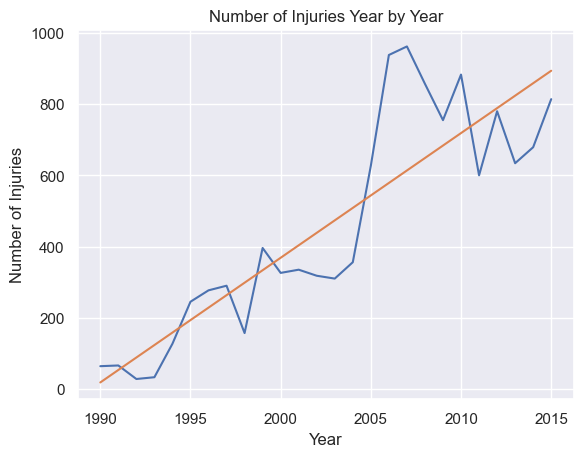

In [15]:
sns.set(style="darkgrid")
sns.lineplot(x=train_data['Year'], y=train_data['Injuries'], data=train_data)
sns.lineplot(x=train_data['Year'], y=train_data['prediction_insample'], data=train_data)
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')


### <u>Time to test on a new set of data:<u>

In [16]:
test_data = df[26:]
 
X_test = np.array(test_data[['Year', 'Players']]).reshape([-1, 2])
y_test = test_data['Injuries']
X_test

array([[2016.,  450.],
       [2017.,  450.],
       [2018.,  450.],
       [2019.,  450.],
       [2020.,  450.],
       [2021.,  450.],
       [2022.,  450.],
       [2023.,  450.]])

In [17]:
y_pred = fit_model.predict(X_test)
y_pred

array([ 928.78769231,  963.80615385,  998.82461538, 1033.84307692,
       1068.86153846, 1103.88      , 1138.89846154, 1173.91692308])

In [18]:
## Now let's evaluate the models performance 
## Using R-Squared score to determine the performance of the model
from sklearn.metrics import mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error:", mae)
print("R-squared Score:", r2)

Mean Squared Error (MSE): 125754.92860236781
Mean Absolute Error: 271.875
R-squared Score: -0.16087070408513537


In [19]:
df.describe()["Injuries"]

count      34.000000
mean      576.058824
std       381.342282
min        28.000000
25%       295.000000
50%       585.000000
75%       851.500000
max      1582.000000
Name: Injuries, dtype: float64

## As seen above, or model is not performing optimally

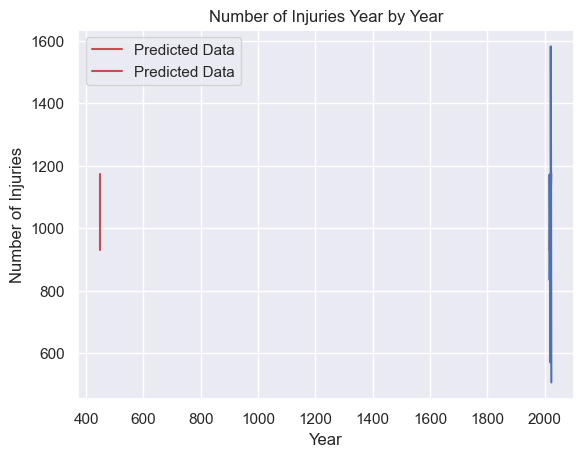

In [20]:
plt.plot(X_test, y_pred, 'r-', label='Predicted Data')
sns.set(style="darkgrid")
sns.lineplot(x=test_data['Year'], y=test_data['Injuries'], data=test_data)
plt.legend()
plt.xlabel('Year')
plt.ylabel('Number of Injuries')
plt.title('Number of Injuries Year by Year')
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
plt.show()

In [21]:
# Now let's remove all the rows from the data frame that have data before 1990
injuryData = injuryData[injuryData['Year'] >= 1990]